In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=23d660da7d308944ccaa2297d91978bfc93547f7c0ea239f73d5647c4dd92e0b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Price Analysis").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Import Data

In [38]:
import pandas as pd

# Import data
df = spark.read.csv('/content/drive/Shared drives/Big Data Analytics/Final Project/car_price_prediction.csv', header=True, inferSchema=True)
df.show(10)

+--------+-----+----+------------+--------+----------+---------+----------------+---------+-------------+---------+---------+-------------+------------+-----+----------------+------+-------+
|      ID|Price|Levy|Manufacturer|   Model|Prod. year| Category|Leather interior|Fuel type|Engine volume|  Mileage|Cylinders|Gear box type|Drive wheels|Doors|           Wheel| Color|Airbags|
+--------+-----+----+------------+--------+----------+---------+----------------+---------+-------------+---------+---------+-------------+------------+-----+----------------+------+-------+
|45654403|13328|1399|       LEXUS|  RX 450|      2010|     Jeep|             Yes|   Hybrid|          3.5|186005 km|        6|    Automatic|         4x4|  4-5|      Left wheel|Silver|     12|
|44731507|16621|1018|   CHEVROLET| Equinox|      2011|     Jeep|              No|   Petrol|            3|192000 km|        6|    Tiptronic|         4x4|  4-5|      Left wheel| Black|      8|
|45774419| 8467|   -|       HONDA|     FIT|  

In [5]:
from pyspark.sql.functions import isnan, when, count, col
# Wrap the column name with a period in backticks directly within the list comprehension, check null values
df.select([count(when(isnan("`" + c + "`" if c == "Prod. year" else c), c)).alias(c) for c in df.columns]).show()

+---+-----+----+------------+-----+----------+--------+----------------+---------+-------------+-------+---------+-------------+------------+-----+-----+-----+-------+
| ID|Price|Levy|Manufacturer|Model|Prod. year|Category|Leather interior|Fuel type|Engine volume|Mileage|Cylinders|Gear box type|Drive wheels|Doors|Wheel|Color|Airbags|
+---+-----+----+------------+-----+----------+--------+----------------+---------+-------------+-------+---------+-------------+------------+-----+-----+-----+-------+
|  0|    0|   0|           0|    0|         0|       0|               0|        0|            0|      0|        0|            0|           0|    0|    0|    0|      0|
+---+-----+----+------------+-----+----------+--------+----------------+---------+-------------+-------+---------+-------------+------------+-----+-----+-----+-------+



In [6]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
# Removing ' km' and any extra spaces, and converting to integer
df = df.withColumn("Mileage", regexp_replace(col("Mileage"), " km", ""))
df = df.withColumn("Mileage", regexp_replace(col("Mileage"), " ", ""))
df = df.withColumn("Mileage", col("Mileage").cast(IntegerType()))
df.show()

+--------+-----+----+-------------+--------+----------+-----------+----------------+---------+-------------+-------+---------+-------------+------------+-----+----------------+------+-------+
|      ID|Price|Levy| Manufacturer|   Model|Prod. year|   Category|Leather interior|Fuel type|Engine volume|Mileage|Cylinders|Gear box type|Drive wheels|Doors|           Wheel| Color|Airbags|
+--------+-----+----+-------------+--------+----------+-----------+----------------+---------+-------------+-------+---------+-------------+------------+-----+----------------+------+-------+
|45654403|13328|1399|        LEXUS|  RX 450|      2010|       Jeep|             Yes|   Hybrid|          3.5| 186005|        6|    Automatic|         4x4|  4-5|      Left wheel|Silver|     12|
|44731507|16621|1018|    CHEVROLET| Equinox|      2011|       Jeep|              No|   Petrol|            3| 192000|        6|    Tiptronic|         4x4|  4-5|      Left wheel| Black|      8|
|45774419| 8467|   -|        HONDA|     

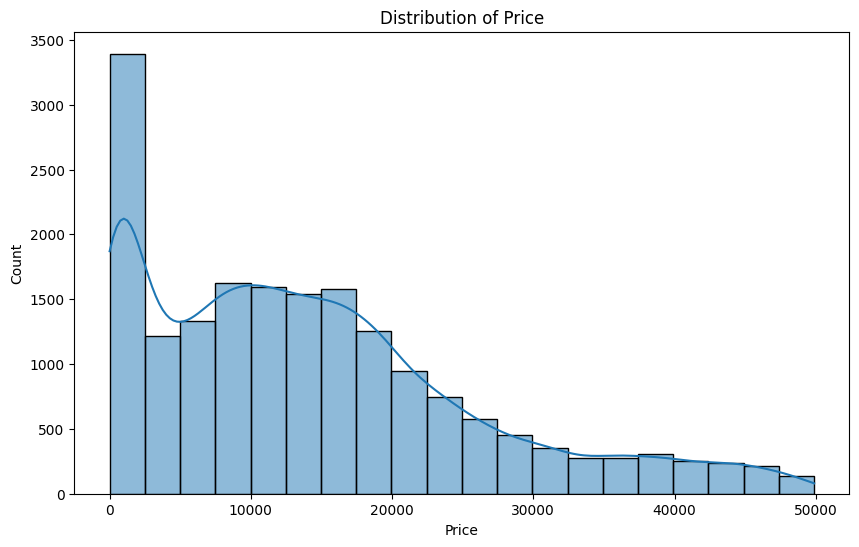

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data in PySpark
filtered_df = df.filter(df['Price'] < 50000)

# Convert to Pandas DataFrame for visualization
filtered_pd_df = filtered_df.select("Price").toPandas()

# Plotting
plt.figure(figsize=(10, 6), facecolor='none')
ax = plt.gca()
ax.set_facecolor('none')
sns.histplot(data=filtered_pd_df['Price'], bins=20, kde=True, ax=ax)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')
ax.patch.set_alpha(0)
plt.show()


<ipython-input-8-69ed77db5bbe>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_manufacturers_pd['count'], y=top_manufacturers_pd['Manufacturer'], palette='Set1')


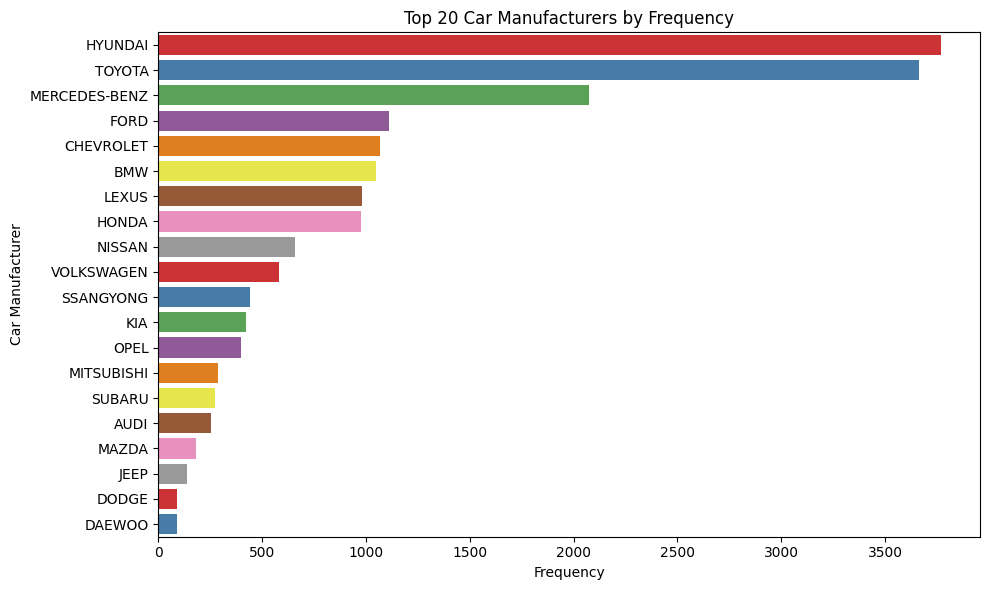

In [8]:
from pyspark.sql.functions import desc

# Count occurrences of each manufacturer and order them
top_manufacturers = df.groupBy("Manufacturer").count().orderBy(desc("count"))

# Take the top 20 manufacturers
top_n_manufacturers = top_manufacturers.limit(20)

# Collect data to Pandas for visualization
top_manufacturers_pd = top_n_manufacturers.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_manufacturers_pd['count'], y=top_manufacturers_pd['Manufacturer'], palette='Set1')
plt.title('Top 20 Car Manufacturers by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Car Manufacturer')
plt.tight_layout()
plt.show()

<ipython-input-9-9f092b2ab895>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories_pd['count'], y=top_categories_pd['Category'], palette='Set3')


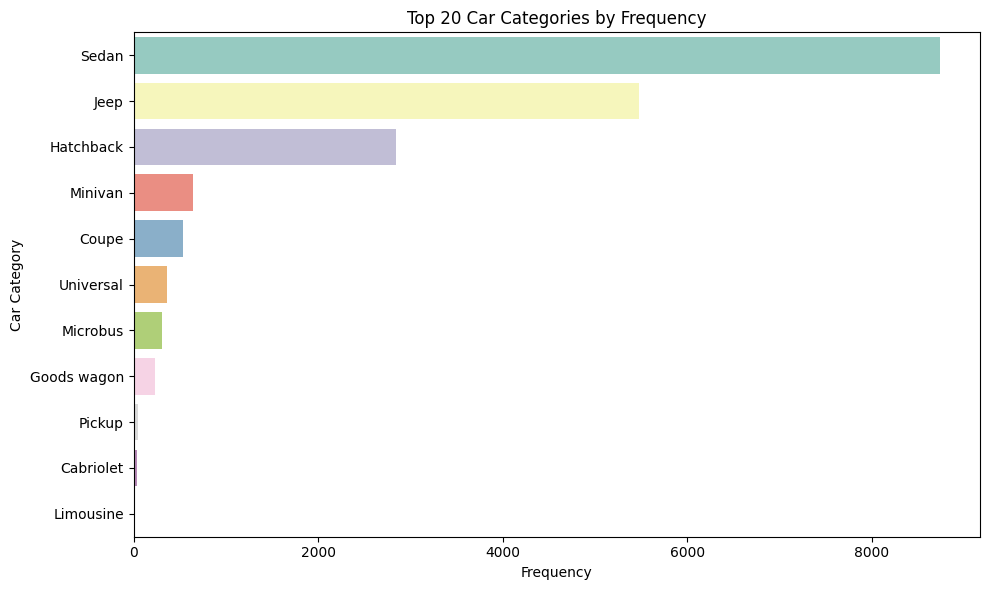

In [9]:
# Aggregate data
top_categories = df.groupBy("Category").count().orderBy(desc("count"))

# Take the top 20 categories
top_n_categories = top_categories.limit(20)

# Convert to Pandas DataFrame for visualization
top_categories_pd = top_n_categories.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories_pd['count'], y=top_categories_pd['Category'], palette='Set3')
plt.title('Top 20 Car Categories by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Car Category')
plt.tight_layout()
plt.show()

<ipython-input-10-ec610f26b46b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fuel type', y='Price', data=filtered_pd_df, palette='Set2')


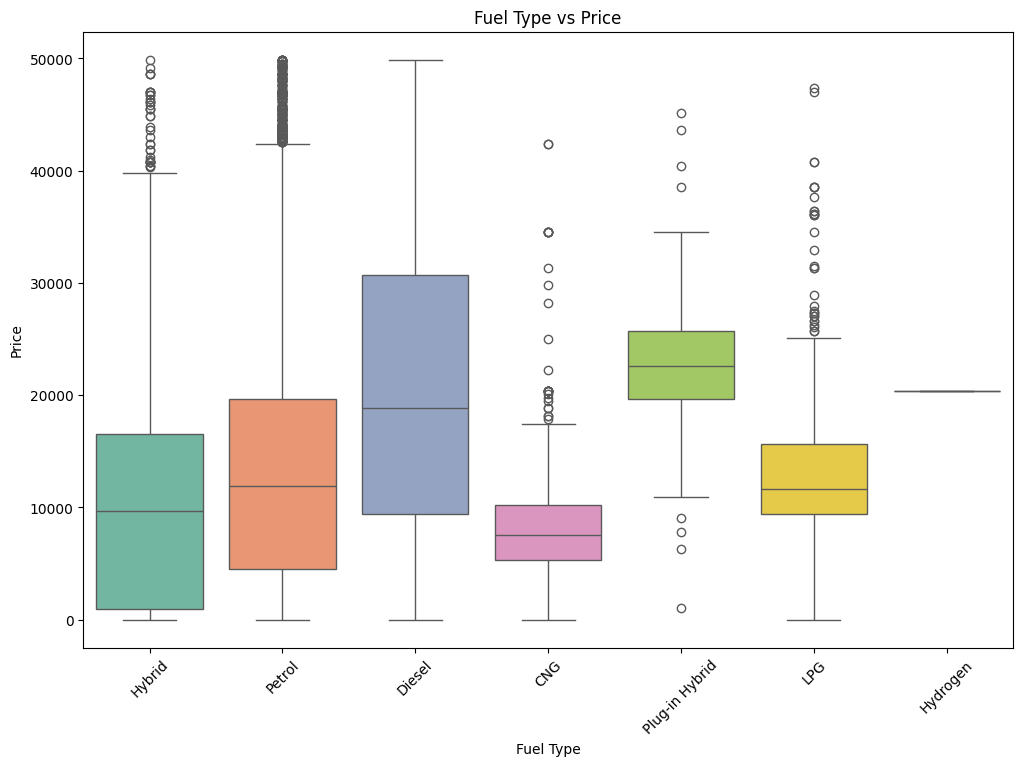

In [10]:
# Plotting the relationship between Fuel type and Price
filtered_df = df.filter(df['Price'] < 50000)

# Collect data to Pandas for visualization
filtered_pd_df = filtered_df.select("Fuel type", "Price").toPandas()

# Visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x='Fuel type', y='Price', data=filtered_pd_df, palette='Set2')
plt.title('Fuel Type vs Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

<ipython-input-11-c97e1e58930f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Doors', y='Price', data=filtered_pd_df, palette='Set1')


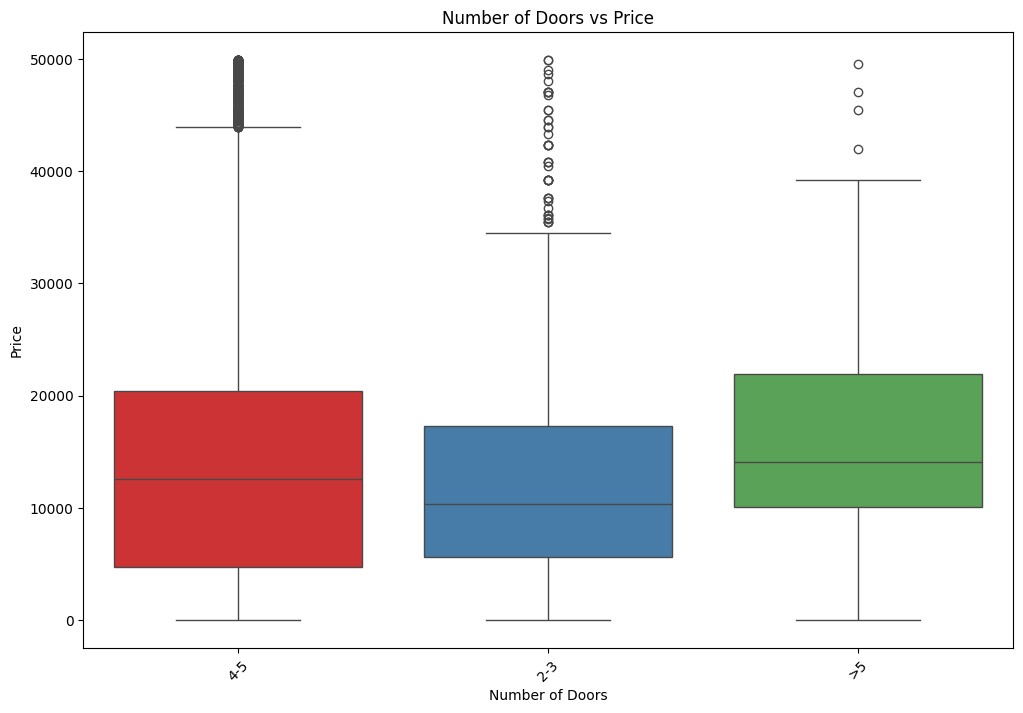

In [11]:
# Collect data to Pandas for visualization
filtered_pd_df = filtered_df.select("Doors", "Price").toPandas()

# Visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x='Doors', y='Price', data=filtered_pd_df, palette='Set1')
plt.title('Number of Doors vs Price')
plt.xlabel('Number of Doors')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [39]:
import numpy as np
df= df.toPandas()

df.replace('-', np.nan, inplace=True)
df['Mileage'] = df['Mileage'].str.replace(' km', '').str.replace(' ', '').astype(int)

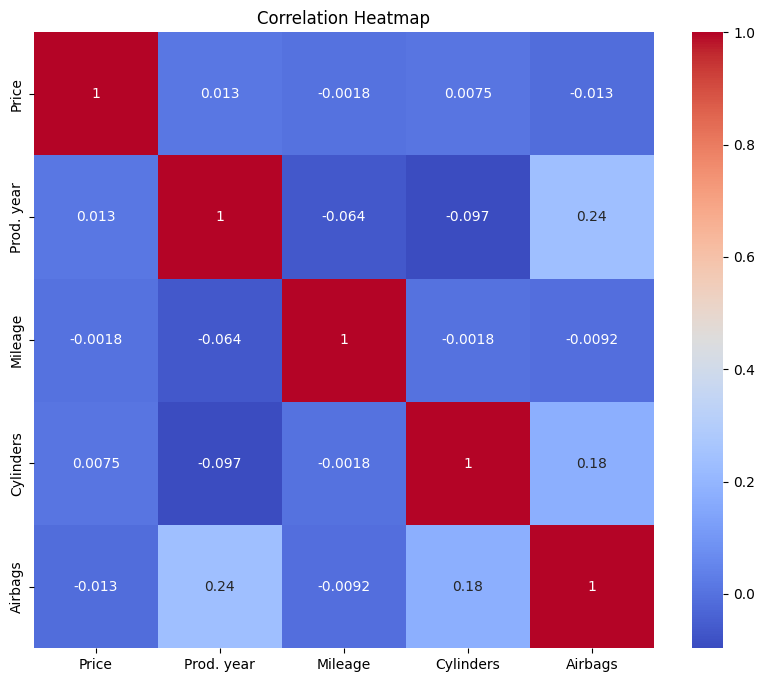

In [40]:
# Distribution of Numerical Features
numerical_features = ['Price', 'Prod. year', 'Mileage', 'Cylinders', 'Airbags']

# Correlation Analysis
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8), facecolor='none')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Data Pre-processing

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
df_dummies = pd.get_dummies(df[['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']],dtype=int, drop_first=True)
df_dummies

,Manufacturer_ALFA ROMEO,Manufacturer_ASTON MARTIN,Manufacturer_AUDI,Manufacturer_BENTLEY,Manufacturer_BMW,Manufacturer_BUICK,Manufacturer_CADILLAC,Manufacturer_CHEVROLET,Manufacturer_CHRYSLER,Manufacturer_CITROEN,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19234,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19235,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df_encoded = pd.concat([df_dummies,df[['Price','Levy','Prod. year','Engine volume','Mileage','Cylinders','Airbags']]], axis = 1)
df_encoded.head()

,Manufacturer_ALFA ROMEO,Manufacturer_ASTON MARTIN,Manufacturer_AUDI,Manufacturer_BENTLEY,Manufacturer_BMW,Manufacturer_BUICK,Manufacturer_CADILLAC,Manufacturer_CHEVROLET,Manufacturer_CHRYSLER,Manufacturer_CITROEN,...,Color_Sky blue,Color_White,Color_Yellow,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13328,1399,2010,3.5,186005,6,12
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,16621,1018,2011,3,192000,6,8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8467,NaN,2006,1.3,200000,4,2
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,3607,862,2011,2.5,168966,4,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,11726,446,2014,1.3,91901,4,4


In [44]:
# Check the values to see if it carries units
df_encoded['Engine volume'].value_counts()

Engine volume
2            3916
2.5          2277
1.8          1760
1.6          1462
1.5          1321
             ... 
6.8             1
6.7             1
3.1             1
0.8 Turbo       1
1.1 Turbo       1
Name: count, Length: 107, dtype: int64

In [45]:
# Split the string on space and keep only the first part (the numeric part)
df_encoded['Engine volume'] = df_encoded['Engine volume'].str.split().str[0].astype(float)

In [46]:
df_encoded.dropna(inplace = True)

In [47]:
df_encoded.shape

(13418, 1700)

In [48]:
x = df_encoded.drop('Price', axis = 1)
y = df_encoded['Price']

In [49]:
# Split dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# Model Training / Testing / Evaluation

In [50]:
model = LinearRegression().fit(X_train, y_train)

# Predict y using X test
y_pred = model.predict(X_test)

In [51]:
# Calculate OOS R^2, MSE, and RMSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2:", round(r2,4))
print("MSE:", round(mse,2))
print("RMSE:", round(rmse,2))

R^2: 0.2456
MSE: 227422743.74
RMSE: 15080.54


In [52]:
# Compare the test and training results with R2 score
r2_train = model.score(X_train, y_train)
r2_test = r2_score (y_test, y_pred)

print("R^2 in train set:", round(r2_train,2))
print("R^2 in test set:", round(r2_test,2))

R^2 in train set: 0.65
R^2 in test set: 0.25


the R-squared (R²) value for the test set (0.25) is way lower than that for the training set (0.65). This means the model fits the training data better than the test data. Applying Lesso seems a reasonable action to take.

# Lasso Regression

In [53]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
# Scale all of the X variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Initialize and fit the LassoCV regressor, and LassoCV does cross validation and find the optimal alpha value
lasso_cv = LassoCV(cv=10, random_state=128, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

# The best alpha value found
print("Best alpha value:", lasso_cv.alpha_)


Best alpha value: 82.58893219297246


In [55]:
print("Lasso coefficients:", lasso_cv.coef_)
print("Intercept:", lasso_cv.intercept_)

Lasso coefficients: [    0.             0.          -677.8882622  ...    23.22774316
  -229.37193786 -3439.10301506]
Intercept: 17323.06810136012


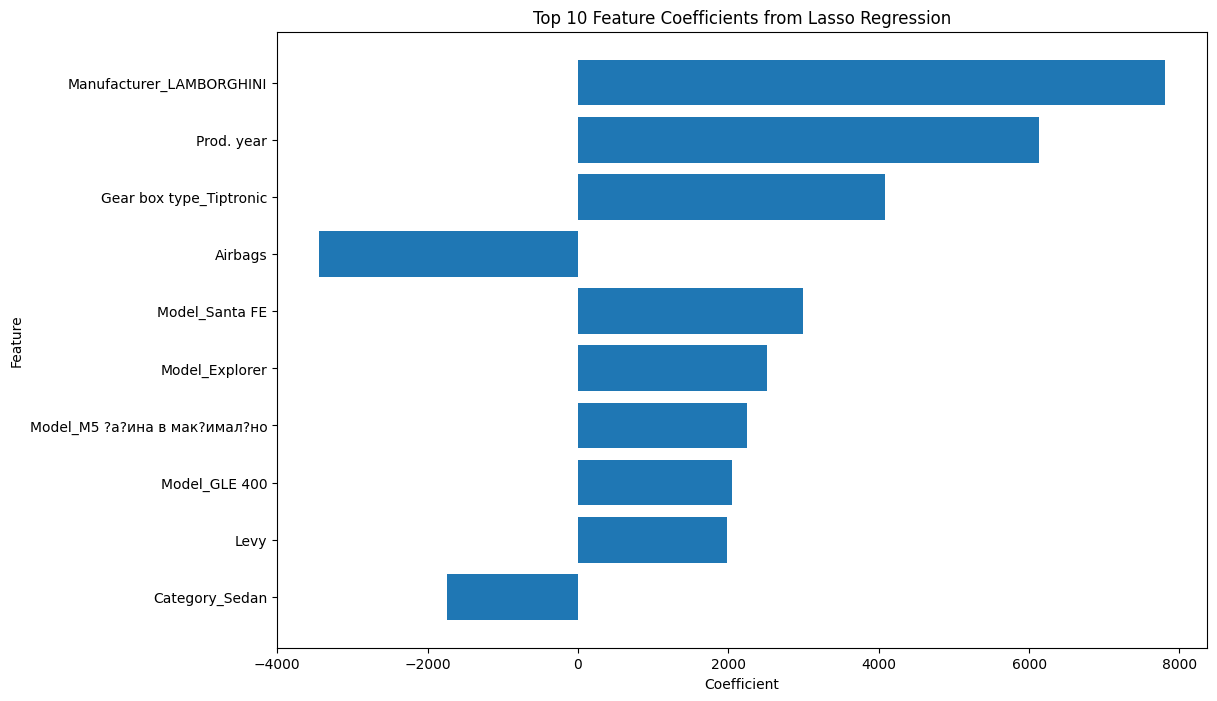

In [56]:
# Create a DataFrame for visualization
coefficients_df = pd.DataFrame({
    'Feature': x.columns,
    'Coefficient': lasso_cv.coef_
})

# Sort the DataFrame by the absolute value of the coefficients and select the top 10 features
top_coefficients_df = coefficients_df.reindex(coefficients_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

# Plot the top 10 coefficients
plt.figure(figsize=(12, 8))
plt.barh(top_coefficients_df['Feature'], top_coefficients_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Feature Coefficients from Lasso Regression')
plt.gca().invert_yaxis()
plt.show()

In [57]:
# Precict y using the lasso model
y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

In [58]:
r2_lasso = r2_score(y_train, y_train_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

oos_r2_lasso = r2_score(y_test, y_test_pred_lasso)
oos_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

print("Training R²:", r2_lasso)
print("Training RMSE:", rmse_lasso)

print("Test R² OOS R^2", oos_r2_lasso)
print("Test R² OOS RMSE:", oos_rmse_lasso)

Training R²: 0.6392103379413117
Training RMSE: 11917.230509553738
Test R² OOS R^2 0.4224587103103815
Test R² OOS RMSE: 13194.522227920615


The Lasso Regression has a R-Squared value of 0.42 for OOS, which is higher than Linear Regression's. And also a lower RMSE, so we can say that it has better performance. But let's explore more models.

# Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor

# fit a random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)
prediction = rf_model.predict(X_test_scaled)

# get rmse, and r2 of the model performance using OOS
rmse_rf = np.sqrt(mean_squared_error(y_test, prediction))
r2_rf = r2_score(y_test, prediction)

print("R-Squared:", r2_rf)
print("RMSE:", rmse_rf)

R-Squared: 0.7767541765669987
RMSE: 8203.3987322351


Random Forest Model has a R-Squared value of 0.78 with even lower RMSE, which performs better than both linear and lasso regression models.

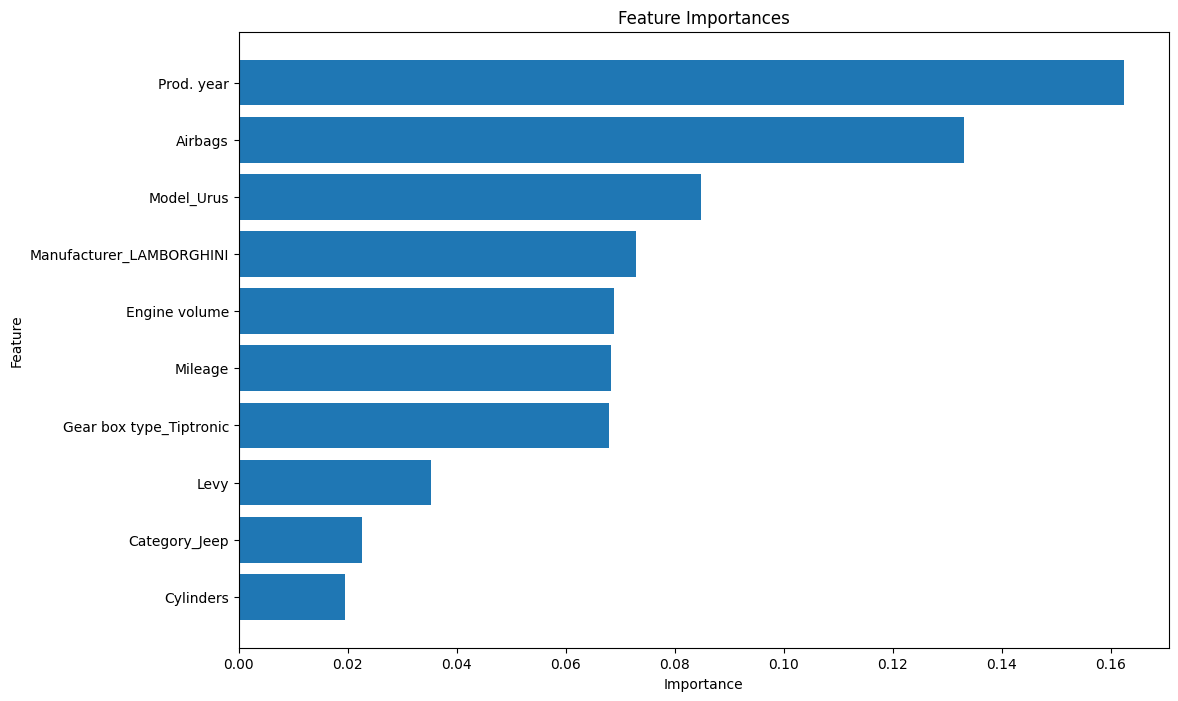

In [60]:
feature_importances  = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the feature importances
plt.figure(figsize=(12, 8), facecolor='none')
ax = plt.gca()
ax.set_facecolor("none")
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()

# Remove axis background
ax.patch.set_alpha(0)

plt.show()


In [61]:
feature_importances_df.head(10)

,Feature,Importance
1694,Prod. year,0.162545
1698,Airbags,0.133099
1513,Model_Urus,0.084873
30,Manufacturer_LAMBORGHINI,0.072947
1695,Engine volume,0.068850
1696,Mileage,0.068372
1671,Gear box type_Tiptronic,0.067953
1693,Levy,0.035231
1656,Category_Jeep,0.022584
1697,Cylinders,0.019503


# Model Deployment

In [62]:
def predict_car_price(x):
  x_scaled = scaler.transform(x)
  predicted_price = rf_model.predict(x_scaled)
  return predicted_price


def main():
    cars = []
    car = {}

    print("\nEnter car details:")

    # Dropdown choices for certain fields
    brand_choices = df['Manufacturer'].unique()
    model_choices = df['Model'].unique()
    category_choices = df['Category'].unique()

    Leather_choices = df['Leather interior'].unique()
    gearbox_choices = df['Gear box type'].unique()
    drivewheels_choices = df['Drive wheels'].unique()

    num_doors_choices = df['Doors'].unique()
    color_choices = df['Color'].unique()
    hand_drive_choices = df['Wheel'].unique()
    fuel_choices = df['Fuel type'].unique()

    # Function to prompt user with dropdown options
    def prompt_with_dropdown(message, choices):
        print(message)
        for i, choice in enumerate(choices, 1):
            print(f"{i}. {choice}")
        choice_index = int(input("Choose an option: ")) - 1
        return choices[choice_index]

    car['Manufacturer'] = prompt_with_dropdown('Brand:', brand_choices)
    car['Model'] = prompt_with_dropdown('Model:', model_choices)
    car['Category'] = prompt_with_dropdown('Category:', category_choices)

    car['Leather interior'] = prompt_with_dropdown('Leather interior:', Leather_choices)
    car['Gear box type'] = prompt_with_dropdown('Gear box type:', gearbox_choices)
    car['Drive wheels'] = prompt_with_dropdown('Drive wheels:', drivewheels_choices)

    car['Color'] = prompt_with_dropdown('Color:', color_choices)
    car['Doors'] = prompt_with_dropdown('Number of Doors:', num_doors_choices)
    car['Wheel'] = prompt_with_dropdown("Hand Drive: ", hand_drive_choices)
    car['Fuel type'] = prompt_with_dropdown("Fuel Type: ", fuel_choices)


    car['Prod. year'] = input("Production Year: ")
    car['Levy'] = input("Levy: ")
    car['Engine volume'] = input("Engine Volume: ")
    car['Mileage'] = input("Mileage: ")
    car['Cylinders'] = input("Cylinders: ")
    car['Airbags'] = input("Airbags: ")


    cars.append(car)


    # Print the details entered by the user
    print("\nCar details entered:")
    for i, car in enumerate(cars, 1):
        for key, value in car.items():
            print(f"{key}: {value}")

    # Create a DataFrame from the entered data
    car_df = pd.DataFrame(cars)

    # transform data entered
    car_df_dummy = pd.get_dummies(car_df[['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']], dtype=int, drop_first=True)
    car_df_encoded = pd.concat([car_df_dummy, car_df[['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']]], axis=1)

    # Align the new data to have the same columns as the training data
    training_columns = X_train.columns
    car_df_encoded = car_df_encoded.reindex(columns=training_columns, fill_value=0)

    # Predict price
    predicted_price = predict_car_price(car_df_encoded)
    print("\nPredicted price for the car: $", predicted_price)


if __name__ == "__main__":
    main()



Enter car details:
Brand:
1. LEXUS
2. CHEVROLET
3. HONDA
4. FORD
5. HYUNDAI
6. TOYOTA
7. MERCEDES-BENZ
8. OPEL
9. PORSCHE
10. BMW
11. JEEP
12. VOLKSWAGEN
13. AUDI
14. RENAULT
15. NISSAN
16. SUBARU
17. DAEWOO
18. KIA
19. MITSUBISHI
20. SSANGYONG
21. MAZDA
22. GMC
23. FIAT
24. INFINITI
25. ALFA ROMEO
26. SUZUKI
27. ACURA
28. LINCOLN
29. VAZ
30. GAZ
31. CITROEN
32. LAND ROVER
33. MINI
34. DODGE
35. CHRYSLER
36. JAGUAR
37. ISUZU
38. SKODA
39. DAIHATSU
40. BUICK
41. TESLA
42. CADILLAC
43. PEUGEOT
44. BENTLEY
45. VOLVO
46. IVECO
47. HAVAL
48. HUMMER
49. SCION
50. GONOW
51. UAZ
52. MERCURY
53. ZAZ
54. ROVER
55. SEAT
56. LANCIA
57. MOSKVICH
58. MASERATI
59. FERRARI
60. SAAB
61. LAMBORGHINI
62. ROLLS-ROYCE
63. PONTIAC
64. SATURN
65. ASTON MARTIN
66. GREATWALL
Choose an option: 5
Model:
1. RX 450
2. Equinox
3. FIT
4. Escape
5. Santa FE
6. Prius
7. Sonata
8. Camry
9. RX 350
10. E 350
11. Transit
12. Vectra
13. CHR
14. Elantra
15. RX 400
16. E 220
17. GX 470
18. Highlander
19. Vito
20. Cayenne
21